In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import matplotlib as mpl
import seaborn as sns
import string
from itertools import cycle
from shapely import geometry, ops
from scipy import stats

In [7]:
gcms = ['GFDL-ESM2M', 'HADGEM2-ES', 'IPSL-CM5A-LR', 'MIROC5']
hms = ['clm45', 'jules-w1', 'orchidee', 'matsiro', 'lpjml', 'h08', 'pcr-globwb', 'watergap2']
rcps = ['rcp26', 'rcp60', 'rcp85']
sspsn = ['SSP1', 'SSP2', 'SSP3', 'SSP4', 'SSP5']
ths = [0.3, 0.2, 0.1, 0.05, 0.01]

ngcm = len(gcms)
nhm = len(hms)
nrcp = len(rcps)
nssp = len(sspsn)
nth = len(ths)
npt = 2
ny = 1128//12

inpath = '../../2_pipeline/global_iri_smd/store/'
dsi = xr.open_dataset(inpath+'orchidee_hadgem2-es_rcp60_2K.nc')
lats, lons = dsi.lat.values, dsi.lon.values
nlat, nlon = lats.size, lons.size
ngrd = nlat*nlon

dscountries = xr.load_dataarray('../../2_pipeline/global_iri_smd/store/countries.nc')
countries = dscountries.values
isos = dscountries.ISO
ncoun = len(isos)

def label_axes(fig, labels=None, loc=None, **kwargs):
    if labels is None:
        labels = string.ascii_lowercase
        
    # re-use labels rather than stop labeling
    labels = cycle(labels)
    if loc is None:
        loc = (.9, .9)
    for ax, lab in zip(fig, labels):
        ax.annotate(lab, xy=loc,
                    xycoords='axes fraction',
                    **kwargs)

# 1. Dpr

In [3]:
infile = '../../2_pipeline/global_iri_smd/store/expths/dpr_ensstats.nc'
ds = xr.load_dataset(infile)

In [4]:
ensemean = ds['DPr_ensmean'].values
dpr_emean = ds['DPr_ch_ensmean'].values
dpr_esnr = ds['DPr_ch_snr'].values
dpr_eagg = ds['DPr_ch_agg'].values

<ipython-input-9-78ee7cafc996>:32: DeprecationWarning: The background_patch property is deprecated. Use GeoAxes.patch instead.
  ax.background_patch.set_visible(False)
<ipython-input-9-78ee7cafc996>:33: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


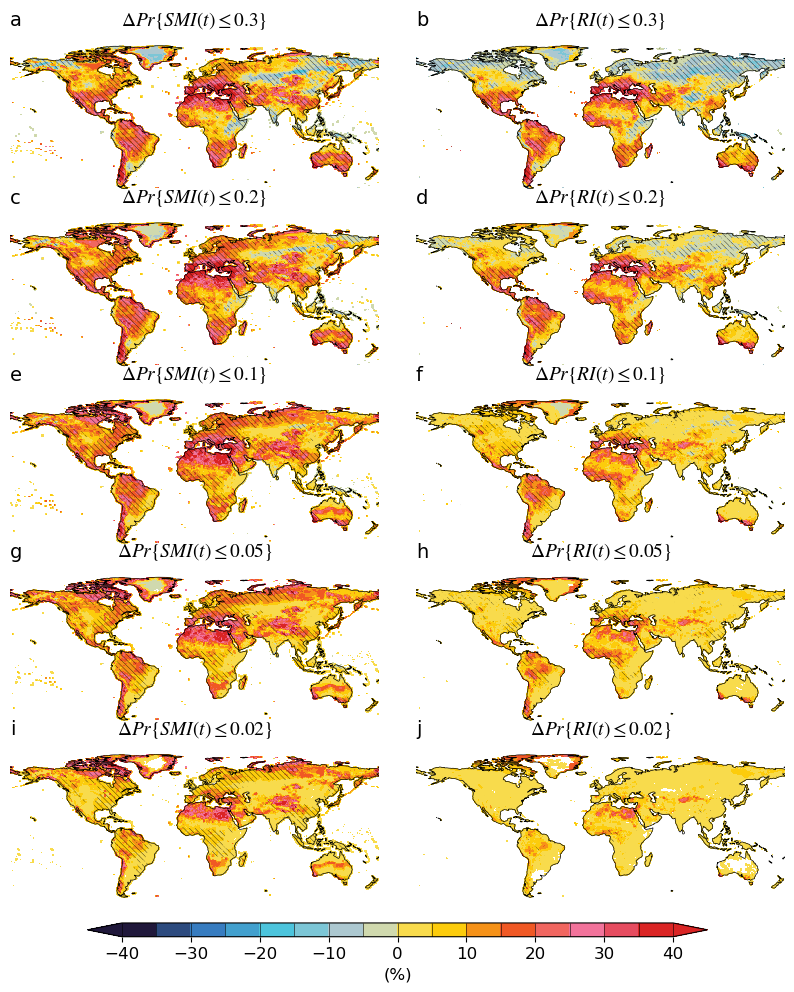

In [9]:
cm = ['#20183B','#377CC0','#4CC4DC','#ACC8D0','#F3EA8C','#FCCC0C','#F05824','#F2739B','#DA2424']
titles = [['$\Delta Pr\{SMI(t) \leq 0.3\}$',
           '$\Delta Pr\{SMI(t) \leq 0.2\}$',
           '$\Delta Pr\{SMI(t) \leq 0.1\}$',
           '$\Delta Pr\{SMI(t) \leq 0.05\}$',
           '$\Delta Pr\{SMI(t) \leq 0.02\}$'],
            ['$\Delta Pr\{RI(t) \leq 0.3\}$',
           '$\Delta Pr\{RI(t) \leq 0.2\}$',
           '$\Delta Pr\{RI(t) \leq 0.1\}$',
           '$\Delta Pr\{RI(t) \leq 0.05\}$',
           '$\Delta Pr\{RI(t) \leq 0.02\}$']]
mpl.rcParams['hatch.linewidth'] = 0.25
mpl.rcParams['mathtext.fontset'] = 'stix'
levels = np.arange(-40,40.1,5)
cmap = mpl.colors.LinearSegmentedColormap.from_list('cm', cm, N=levels.size)
fig, axes = plt.subplots(5,2, sharex=True, sharey=True, dpi=100, figsize=(10,14), 
                         gridspec_kw={'wspace':0.1, 'hspace':0.05},
                         subplot_kw={'projection': ccrs.PlateCarree(), 'frameon':False}, )
ss = 2 # index for rcp8.5
Ti = 1 # index for 2071-2100
for i, thi in enumerate([0,1,2,3,4]):
    for di in range(2):
        ys = dpr_emean[di, ss, thi, Ti].reshape(nlat, nlon)*100
        z = (dpr_eagg[di, ss, thi, Ti].reshape(nlat, nlon)>=66)*1
        ys[ys==0] = np.nan
        z = np.where(np.isnan(ys), np.nan, z)
        ax = axes[i, di]
        ax.set_title(titles[di][thi], fontsize=14)
        ax.coastlines(linewidth=0.5, resolution="110m")
        cs = ax.contourf(lons, lats, ys, levels=levels,cmap=cmap,transform=ccrs.PlateCarree(), extend='both')
        ax.contourf(lons, lats, z, levels=[-0.9, .9, 1.2], hatches=['', '\\\\\\\\\\\\', ''], colors='none', alpha=0.)
        ax.background_patch.set_visible(False)
        ax.outline_patch.set_visible(False)
        ax.set_ylim(-60, 95)
cbar = fig.colorbar(cs, ax=axes, orientation='horizontal', pad=0.02, shrink=0.8, drawedges=True, aspect=40, 
                    extendfrac='auto', spacing='uniform',)
cbar.ax.tick_params(axis='x', labelsize=12)
cbar.ax.set_xlabel('(%)', fontsize=12)
label_axes(axes.ravel(), loc=(0., 1.05), fontsize=14)

# 2. Exposed people

# 2.1 Load data

In [10]:
inpath = '../../2_pipeline/global_iri_smd/store/expths/SMIthexp/'
ncfs = os.listdir(inpath)
ensexp_ncoun = np.full((2, nrcp, ngcm, nhm, npt, nssp, nth, ny, ncoun), np.nan)
ensexp_glob = np.full((2, nrcp, ngcm, nhm, npt, nssp, nth, ny), np.nan)
for ncf in ncfs:
    hmi, gcmi, rcpi = ncf.split('_')[:3]
    hmidx, gcmidx, rcpidx = hms.index(hmi), gcms.index(gcmi.upper()), rcps.index(rcpi)
    ds = xr.load_dataset(inpath+ncf)
    ensexp_ncoun[0, rcpidx, gcmidx, hmidx] = ds['exp_cn'].values
    ensexp_glob[0, rcpidx, gcmidx, hmidx] = ds['exp_glob'].values
    print(ncf)
inpath = '../../2_pipeline/global_iri_smd/store/expths/RIthexp/'
ncfs = os.listdir(inpath)
for ncf in ncfs:
    hmi, gcmi, rcpi = ncf.split('_')[:3]
    hmidx, gcmidx, rcpidx = hms.index(hmi), gcms.index(gcmi.upper()), rcps.index(rcpi)
    ds = xr.load_dataset(inpath+ncf)
    ensexp_ncoun[1, rcpidx, gcmidx, hmidx] = ds['exp_cn'].values
    ensexp_glob[1, rcpidx, gcmidx, hmidx] = ds['exp_glob'].values
    print(ncf)

clm45_gfdl-esm2m_rcp26_SMI.nc
clm45_gfdl-esm2m_rcp60_SMI.nc
clm45_gfdl-esm2m_rcp85_SMI.nc
clm45_hadgem2-es_rcp26_SMI.nc
clm45_hadgem2-es_rcp60_SMI.nc
clm45_hadgem2-es_rcp85_SMI.nc
clm45_ipsl-cm5a-lr_rcp26_SMI.nc
clm45_ipsl-cm5a-lr_rcp60_SMI.nc
clm45_ipsl-cm5a-lr_rcp85_SMI.nc
clm45_miroc5_rcp26_SMI.nc
clm45_miroc5_rcp60_SMI.nc
clm45_miroc5_rcp85_SMI.nc
h08_gfdl-esm2m_rcp26_SMI.nc
h08_gfdl-esm2m_rcp60_SMI.nc
h08_gfdl-esm2m_rcp85_SMI.nc
h08_hadgem2-es_rcp26_SMI.nc
h08_hadgem2-es_rcp60_SMI.nc
h08_hadgem2-es_rcp85_SMI.nc
h08_ipsl-cm5a-lr_rcp26_SMI.nc
h08_ipsl-cm5a-lr_rcp60_SMI.nc
h08_ipsl-cm5a-lr_rcp85_SMI.nc
h08_miroc5_rcp26_SMI.nc
h08_miroc5_rcp60_SMI.nc
h08_miroc5_rcp85_SMI.nc
jules-w1_gfdl-esm2m_rcp26_SMI.nc
jules-w1_gfdl-esm2m_rcp60_SMI.nc
jules-w1_gfdl-esm2m_rcp85_SMI.nc
jules-w1_hadgem2-es_rcp26_SMI.nc
jules-w1_hadgem2-es_rcp60_SMI.nc
jules-w1_hadgem2-es_rcp85_SMI.nc
jules-w1_ipsl-cm5a-lr_rcp26_SMI.nc
jules-w1_ipsl-cm5a-lr_rcp60_SMI.nc
jules-w1_ipsl-cm5a-lr_rcp85_SMI.nc
jules-w1_miro

In [11]:
# cst pop
inpath = '../../2_pipeline/global_iri_smd/store/expths/SMIthexp_cstpop/'
ncfs = os.listdir(inpath)
ensexp_cstpop_ncoun = np.full((2, nrcp, ngcm, nhm, npt, nth, ny, ncoun), np.nan)
ensexp_cstpop_glob = np.full((2, nrcp, ngcm, nhm, npt, nth, ny), np.nan)
for ncf in ncfs:
    hmi, gcmi, rcpi = ncf.split('_')[:3]
    hmidx, gcmidx, rcpidx = hms.index(hmi), gcms.index(gcmi.upper()), rcps.index(rcpi)
    ds = xr.load_dataset(inpath+ncf)
    ensexp_cstpop_ncoun[0, rcpidx, gcmidx, hmidx] = ds['exp_cn'].values
    ensexp_cstpop_glob[0, rcpidx, gcmidx, hmidx] = ds['exp_glob'].values
    print(ncf)
inpath = '../../2_pipeline/global_iri_smd/store/expths/RIthexp_cstpop/'
ncfs = os.listdir(inpath)
for ncf in ncfs:
    hmi, gcmi, rcpi = ncf.split('_')[:3]
    hmidx, gcmidx, rcpidx = hms.index(hmi), gcms.index(gcmi.upper()), rcps.index(rcpi)
    ds = xr.load_dataset(inpath+ncf)
    ensexp_cstpop_ncoun[1, rcpidx, gcmidx, hmidx] = ds['exp_cn'].values
    ensexp_cstpop_glob[1, rcpidx, gcmidx, hmidx] = ds['exp_glob'].values
    print(ncf)
    
# cst clim
inpath = '../../2_pipeline/global_iri_smd/store/expths/SMIthexp_cstclim/'
ncfs = os.listdir(inpath)
ensexp_cstclim_ncoun = np.full((2, ngcm, nhm, npt, nssp, nth, ny, ncoun), np.nan)
ensexp_cstclim_glob = np.full((2, ngcm, nhm, npt, nssp, nth, ny), np.nan)
for ncf in ncfs:
    hmi, gcmi, rcpi = ncf.split('_')[:3]
    hmidx, gcmidx = hms.index(hmi), gcms.index(gcmi.upper()) #rcpidx, rcps.index(rcpi)
    ds = xr.load_dataset(inpath+ncf)
    ensexp_cstclim_ncoun[0, gcmidx, hmidx] = ds['exp_cn'].values
    ensexp_cstclim_glob[0, gcmidx, hmidx] = ds['exp_glob'].values
    print(ncf)
inpath = '../../2_pipeline/global_iri_smd/store/expths/RIthexp_cstclim/'
ncfs = os.listdir(inpath)
for ncf in ncfs:
    hmi, gcmi, rcpi = ncf.split('_')[:3]
    hmidx, gcmidx = hms.index(hmi), gcms.index(gcmi.upper()) #rcpidx, rcps.index(rcpi)
    ds = xr.load_dataset(inpath+ncf)
    ensexp_cstclim_ncoun[1, gcmidx, hmidx] = ds['exp_cn'].values
    ensexp_cstclim_glob[1, gcmidx, hmidx] = ds['exp_glob'].values
    print(ncf)

clm45_gfdl-esm2m_rcp26_SMI.nc
clm45_gfdl-esm2m_rcp60_SMI.nc
clm45_gfdl-esm2m_rcp85_SMI.nc
clm45_hadgem2-es_rcp26_SMI.nc
clm45_hadgem2-es_rcp60_SMI.nc
clm45_hadgem2-es_rcp85_SMI.nc
clm45_ipsl-cm5a-lr_rcp26_SMI.nc
clm45_ipsl-cm5a-lr_rcp60_SMI.nc
clm45_ipsl-cm5a-lr_rcp85_SMI.nc
clm45_miroc5_rcp26_SMI.nc
clm45_miroc5_rcp60_SMI.nc
clm45_miroc5_rcp85_SMI.nc
h08_gfdl-esm2m_rcp26_SMI.nc
h08_gfdl-esm2m_rcp60_SMI.nc
h08_gfdl-esm2m_rcp85_SMI.nc
h08_hadgem2-es_rcp26_SMI.nc
h08_hadgem2-es_rcp60_SMI.nc
h08_hadgem2-es_rcp85_SMI.nc
h08_ipsl-cm5a-lr_rcp26_SMI.nc
h08_ipsl-cm5a-lr_rcp60_SMI.nc
h08_ipsl-cm5a-lr_rcp85_SMI.nc
h08_miroc5_rcp26_SMI.nc
h08_miroc5_rcp60_SMI.nc
h08_miroc5_rcp85_SMI.nc
jules-w1_gfdl-esm2m_rcp26_SMI.nc
jules-w1_gfdl-esm2m_rcp60_SMI.nc
jules-w1_gfdl-esm2m_rcp85_SMI.nc
jules-w1_hadgem2-es_rcp26_SMI.nc
jules-w1_hadgem2-es_rcp60_SMI.nc
jules-w1_hadgem2-es_rcp85_SMI.nc
jules-w1_ipsl-cm5a-lr_rcp26_SMI.nc
jules-w1_ipsl-cm5a-lr_rcp60_SMI.nc
jules-w1_ipsl-cm5a-lr_rcp85_SMI.nc
jules-w1_miro

In [8]:
import json

# HDI SSPs
file = '../../0_data/HDI/HDI-SSPs.csv'
df_ssp = pd.read_csv(file)
index = [(s.split(' - ')[0], int(s.split()[-1]))  for s in df_ssp['obs']]
multidx = pd.MultiIndex.from_tuples(index, names=['country', 'year'])
df_hdi = df_ssp.iloc[:, 1:].set_index(multidx)
df_hdi.dropna(how='all', inplace=True)

# HDI UN
file = '../../0_data/HDI/hdi_9019_un.json'
with open(file, 'r') as myfile:
    data = myfile.read()
# parse file
hdi_un = json.loads(data)

# Correct country name to match UN HDI
corrections = {
                'Bolivia':'Bolivia (Plurinational State of)',
                'Cape Verde':'Cabo Verde',
                'China, Hong Kong SAR':'Hong Kong, China (SAR)',
                'Czech Republic':'Czechia',
                'Democratic Republic of the Congo':'Congo (Democratic Republic of the)',
                'Republic of Korea':'Korea (Republic of)',
                'Republic of Moldova':'Moldova (Republic of)',
                'Swaziland':'Eswatini (Kingdom of)',
                'TFYR Macedonia':'North Macedonia',
                'United Republic of Tanzania':'Tanzania (United Republic of)',
                'United States of America':'United States',
                }
# GET UN HDI in year 2015
tmp = df_hdi.index.get_level_values('country')
cn = np.unique(tmp).tolist()
for ci in cn:
    if ci in corrections.keys():
        cn[cn.index(ci)] = corrections[ci]
hdi_un15 = np.zeros(len(cn))
codes_cn = {}
for i, ci in enumerate(cn):
    for key,value in hdi_un['country_name'].items():
        if value == ci:
            hdi_un15[i] = hdi_un['indicator_value'][key]['137506']['2015']
            codes_cn[ci] = key

index = list(hdi_un['country_name'].keys())
un_hdi15_df = pd.DataFrame(np.zeros((len(index), 1)), index=index, columns=['HDI_2015'])
for idx in index:
    try:
        un_hdi15_df.loc[idx] = hdi_un['indicator_value'][idx]['137506']['2015']
    except:
        #print(idx, hdi_un['indicator_value'][idx])
        continue

# Normalize 1-HDI SSPs: Vulnerability Index (VI)
inv_hdi_un15 = 1-hdi_un15
inv_hdi_ssps = 1-df_hdi.values.ravel()

iqr = np.percentile(inv_hdi_un15, 75)-np.percentile(inv_hdi_un15, 25)
bw = 0.9 * min(iqr, np.std(inv_hdi_un15)) * (inv_hdi_un15.size) ** (-0.2)

outer = (inv_hdi_ssps[:, None]-inv_hdi_un15)/bw
cdf = stats.norm.cdf(outer, *(0, 1)).mean(axis=1)
cdf = cdf.reshape(df_hdi.values.shape)

outer = (inv_hdi_un15[:, None]-inv_hdi_un15)/bw
cdf15 = stats.norm.cdf(outer, *(0, 1)).mean(axis=1)

# Dataframe for VI
tmp = df_hdi.index.get_level_values('country')
allcn = tmp.tolist()
for ci in allcn:
    if ci in corrections.keys():
        allcn[allcn.index(ci)] = corrections[ci]            
tmp = df_hdi.index.get_level_values('year').tolist()
index = pd.MultiIndex.from_arrays([allcn, tmp], names=['country', 'year'])
df_vi = pd.DataFrame(cdf, columns=df_hdi.columns, index=index)
df_vi_nonnorm = pd.DataFrame(1-df_hdi.values, columns=df_hdi.columns, index=index)
df_hdi = pd.DataFrame(df_hdi.values, columns=df_hdi.columns, index=index)

for i, ci in enumerate(cn):
    df_vi.loc[ci, 'HDI_2015'] = np.array([cdf15[i]]*14)
    df_vi_nonnorm.loc[ci, 'HDI_2015'] = np.array([inv_hdi_un15[i]]*14)
df_hdi_un15 = pd.DataFrame(np.stack([hdi_un15]*14).T.ravel(), columns=['HDI_2015'], index=index)

# 2.2 Prepare

In [18]:
ensexp_ncoun_mean = np.nanmean(ensexp_ncoun, axis=(2,3))
ensexp_glob_mean = np.nanmean(ensexp_glob, axis=(2,3))
cstclim_ncoun_mean = np.nanmean(ensexp_cstclim_ncoun, axis=(1,2))
cstpop_ncoun_mean = np.nanmean(ensexp_cstpop_ncoun, axis=(2,3))
cstclim_glob_mean = np.nanmean(ensexp_cstclim_glob, axis=(1,2))
cstpop_glob_mean = np.nanmean(ensexp_cstpop_glob, axis=(2,3))

In [19]:
ensexp_ncoun_mean = np.stack([ensexp_ncoun_mean[0,:,1], ensexp_ncoun_mean[1,:,0]])
ensexp_glob_mean = np.stack([ensexp_glob_mean[0,:,1], ensexp_glob_mean[1,:,0]])

In [20]:
tidx = (slice(-70, -40), slice(-30, None)) # indices for 2031-2060, 2071-2100
Ti = 1 # index for 2071-2100
scs = [(0,0), (1,1), (1,2), (1,3), (2,4)]
cols = [rcps[ri]+'-'+sspsn[si] for ri,si in scs]
tmp = np.stack([ensexp_ncoun_mean[:, ri,si] for ri,si in scs])
dstr = ['SMI', 'RI']
multidx = pd.MultiIndex.from_product((dstr, cols, ths), names=['dd', 'scenarios', 'dclass'])
df_exp = pd.DataFrame(np.zeros((len(isos), len(multidx))), columns=multidx, index=isos)
for iso in isos:
    ci = isos.index(iso)
    vals = np.nanmean(tmp[:, :, :, tidx[Ti],ci], axis=-1)
    for i in range(len(scs)):
        df_exp.loc[iso, (dstr, cols[i], ths)] = vals[i].ravel()
df_exp.dropna(inplace=True)

In [21]:
devclass = ['high', 'low', 'global']
df_exp_dev = pd.DataFrame(np.zeros((len(multidx), len(devclass))), columns=devclass, index=multidx)
for col in cols:
    idx_code = un_hdi15_df[un_hdi15_df.loc[:, 'HDI_2015']>0.8].index.tolist()
    high = df_exp.loc[idx_code, (dstr, col)].sum(axis=0)
    df_exp_dev.loc[high.index, devclass[0]] = high

    idx_code = un_hdi15_df[un_hdi15_df.loc[:, 'HDI_2015']<0.55].index.tolist()
    low = df_exp.loc[idx_code, (dstr, col)].sum(axis=0)
    df_exp_dev.loc[low.index, devclass[1]] = low

In [22]:
tmp_glob = np.stack([ensexp_glob_mean[:, ri,si] for ri,si in scs])
df_exp_dev.loc[:, 'global'] = np.nanmean(tmp_glob[:,:,:,tidx[Ti]], axis=-1).transpose(1,0,2).ravel()

In [23]:
# pop, clim contribution
## total for RI, rural for SMI
cstpop_ncoun_mean = np.stack([cstpop_ncoun_mean[0,:,1], cstpop_ncoun_mean[1,:,0]])
cstclim_ncoun_mean = np.stack([cstclim_ncoun_mean[0,1], cstclim_ncoun_mean[1,0]])

tmp_cclim = np.nanmean(cstpop_ncoun_mean[:,:,:,tidx[Ti]], axis=-2)
tmp_cpop = np.nanmean(cstclim_ncoun_mean[:,:,:,tidx[Ti]], axis=-2)

dstr = ['SMI', 'RI']
multidxc = pd.MultiIndex.from_product((dstr, sspsn+rcps, ths), names=['dd', 'scenarios', 'dclass'])
df_exp_contrib = pd.DataFrame(np.zeros((len(isos), len(multidxc))), columns=multidxc, index=isos)
for iso in isos:
    ci = isos.index(iso)
    df_exp_contrib.loc[iso, (dstr, sspsn, ths)] = tmp_cpop[:,:,:, ci].ravel()
    df_exp_contrib.loc[iso, (dstr, rcps, ths)] = tmp_cclim[:,:,:, ci].ravel()

devclass = ['high', 'low', 'global']
df_exp_contrib_dev = pd.DataFrame(np.zeros((len(multidxc), len(devclass))), columns=devclass, index=multidxc)
for col in sspsn:
    idx_code = un_hdi15_df[un_hdi15_df.loc[:, 'HDI_2015']>0.8].index.tolist()
    high = df_exp_contrib.loc[idx_code].sum(axis=0)
    df_exp_contrib_dev.loc[high.index, devclass[0]] = high

    idx_code = un_hdi15_df[un_hdi15_df.loc[:, 'HDI_2015']<0.55].index.tolist()
    low = df_exp_contrib.loc[idx_code].sum(axis=0)
    df_exp_contrib_dev.loc[low.index, devclass[1]] = low

In [24]:
cstpop_glob_mean = np.stack([cstpop_glob_mean[0,:,1], cstpop_glob_mean[1,:,0]])
cstclim_glob_mean = np.stack([cstclim_glob_mean[0,1], cstclim_glob_mean[1,0]])

tmp_cclim_glob = np.nanmean(cstpop_glob_mean[:,:,:,tidx[Ti]], axis=-1)
tmp_cpop_glob = np.nanmean(cstclim_glob_mean[:,:,:,tidx[Ti]], axis=-1)
df_exp_contrib_dev.loc[(dstr, sspsn, ths), 'global'] = tmp_cpop_glob.ravel()
df_exp_contrib_dev.loc[(dstr, rcps, ths), 'global'] = tmp_cclim_glob.ravel()

In [25]:
cclass = ['cchigh', 'cclow', 'ccglob', 'cphigh', 'cplow', 'cpglob']
df_ccp = pd.DataFrame(np.zeros((len(multidx), len(cclass))), columns=cclass, index=multidx)
for col in cols:
    r, s = col.split('-')
    tt = df_exp_contrib_dev.loc[(dstr, [s,r], ths)].sum(axis=0, level=(0,2))
    cpop = df_exp_contrib_dev.loc[(dstr, s, ths)]/tt
    cclim = df_exp_contrib_dev.loc[(dstr, r, ths)]/tt
    df_ccp.loc[(dstr, col, ths), cclass[:3]] = cclim.values
    df_ccp.loc[(dstr, col, ths), cclass[3:]] = cpop.values

<ipython-input-25-d9d3a20c8036>:5: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  tt = df_exp_contrib_dev.loc[(dstr, [s,r], ths)].sum(axis=0, level=(0,2))


# 2.3 Plots

<ipython-input-28-4c45d1a29397>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  handles = np.array(handles)[[2,3,4,5,6,0,1]]


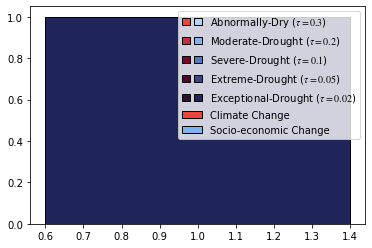

In [28]:
# Prepare a Custom Legend
from matplotlib.legend_handler import HandlerTuple
handles = []
colorp =  ['#F0433A', '#C9283E', '#820333', '#540032', '#2E112D']
colorp_blue = ['#ADD5F7', '#7FB2F0', '#4E7AC7', '#35478C', '#202559']#'#16193B']
colorx = [colorp, colorp_blue]
p1 = plt.bar([1], [1], color=colorx[0][0], edgecolor='k', lw=1.0)
p2 = plt.bar([1], [1], color=colorx[1][1], edgecolor='k', lw=1.0)
handles.append(p1)
handles.append(p2)
for thi in range(nth):
    p1 = plt.bar([1], [1], color=colorx[0][thi], edgecolor='k', lw=1.0)
    p2 = plt.bar([1], [1], color=colorx[1][thi], edgecolor='k', lw=1.0)
    handles.append((p1,p2))
dcnames = ['D0 (Abnormally-Dry)', 'D1 (Moderate-Drought)', 
           'D2 (Severe-Drought)', 'D3 (Extreme-Drought)', 
           'D4 (Exceptional-Drought)']
dcnames = ['Abnormally-Dry ($\\tau = 0.3$)', 'Moderate-Drought ($\\tau=0.2$)', 
           'Severe-Drought ($\\tau=0.1$)', 'Extreme-Drought ($\\tau=0.05$)', 
           'Exceptional-Drought ($\\tau=0.02$)']
scnames = ['Climate Change', 'Socio-economic Change']
handles = np.array(handles)[[2,3,4,5,6,0,1]]
plt.legend(handles, dcnames+scnames, handler_map={tuple: HandlerTuple(ndivide=None)})

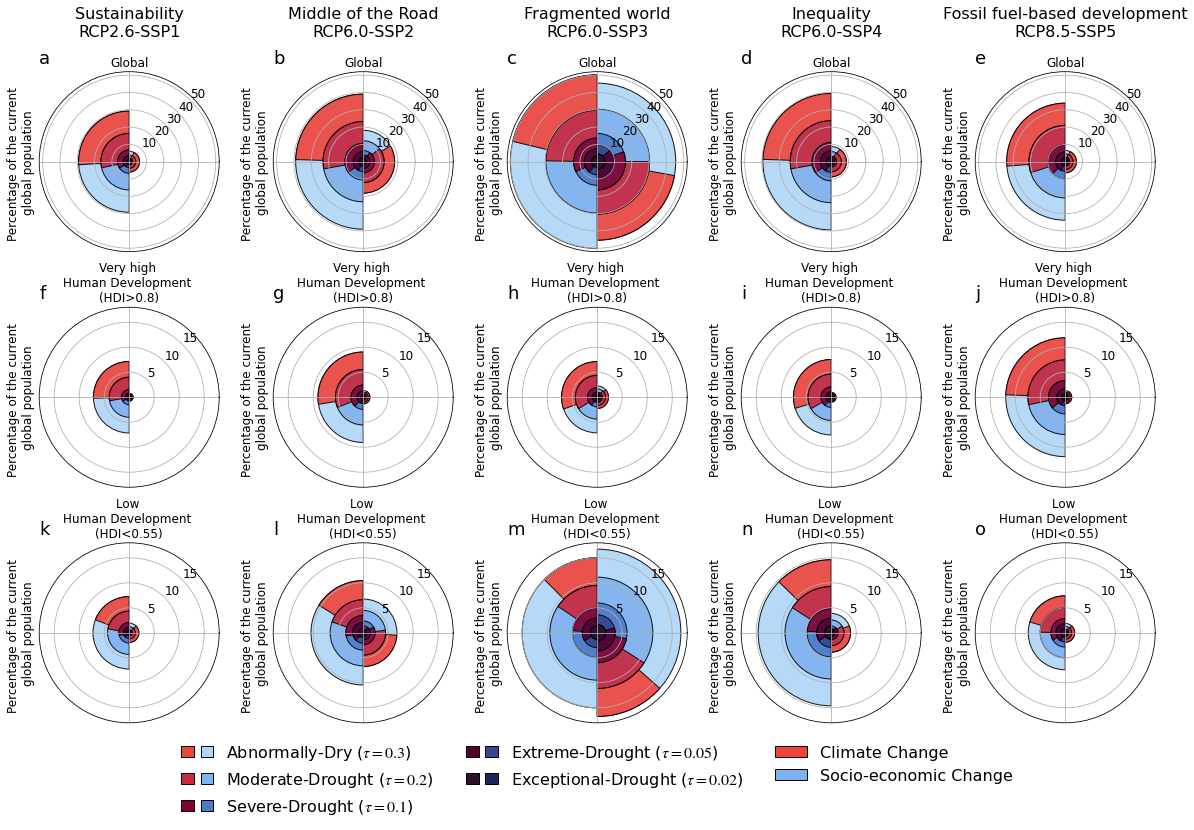

In [29]:

rows = ['global','high', 'low']
idx_ccp = [['ccglob', 'cpglob'], ['cchigh', 'cphigh'], ['cclow', 'cplow']]
titles = ['Global', 'Very high \nHuman Development \n(HDI>0.8)', 
          'Low \nHuman Development \n(HDI<0.55)']
top_titles = ['Sustainability\nRCP2.6-SSP1', 'Middle of the Road\nRCP6.0-SSP2',
              'Fragmented world\nRCP6.0-SSP3', 'Inequality\nRCP6.0-SSP4',
              'Fossil fuel-based development\nRCP8.5-SSP5']
fig, axes = plt.subplots(3, 5, figsize=(20,12), #sharey='row',
                         subplot_kw={'projection':'polar'}, 
                         gridspec_kw={'hspace':0.3, 'wspace':0.3})
x0 = [0, np.pi]
x1 = [-1/2, 1/2]
factor = [3.405*10**9, 6.895*10**9] # average rural and total population in the 2010 decade
for cc in range(3):
    for ss in range(5):
        ax = axes[cc, ss]
        for i in range(2):
            ys = df_exp_dev.loc[(dstr[i], cols[ss]), rows[cc]].values/factor[i]*100
            ys_cont = df_ccp.loc[(dstr[i], cols[ss]), idx_ccp[cc]].values
            for thi in range(nth):
                cci, cpi = ys_cont[thi]
                theta = [np.pi*cci, np.pi]
                xx = [x1[i]*np.pi + theta[0]/2, x0[i]]
                for xi in [1,0]:
                    ax.bar(xx[xi], ys[thi], width=theta[xi], bottom=0.0, alpha=0.9, 
                           facecolor=colorx[xi][thi], edgecolor='k', lw=1.0)
        
        ax.set_xticks([0, np.pi/2, np.pi, np.pi+np.pi/2])
        ax.set_xticklabels([])
        ax.set_rlabel_position(45)  # Move radial labels away from plotted line
        ax.grid(True)
        ax.set_ylabel('Percentage of the current \nglobal population', fontsize=12)
        #ax.set_ylabel('(x100 Million)', fontsize=12)
        ax.set_title(titles[cc], fontsize=12)
        ax.tick_params(axis="y", labelleft=True, which='major', labelsize=12)
for ss, ax in enumerate(axes[0, :]):
    ax.annotate(top_titles[ss], xy=(0.5,1.2), xycoords='axes fraction', fontsize=16, 
                         horizontalalignment='center')
    ax.set_ylim(0, 52)
    ax.set_yticks(np.arange(10,51,10))
for ax in axes[1:].ravel():
    ax.set_ylim(0, 18)
    ax.set_yticks(np.arange(5,16,5))
axes[-1,2].legend(handles, dcnames+scnames, bbox_to_anchor=(0.5, -0.6), loc='lower center',
                 frameon=False, ncol=3, fontsize=16,
                 handler_map={tuple: HandlerTuple(ndivide=None)})
label_axes(axes.ravel(), loc=(0., 1.05), fontsize=18)

# 3. Risk illustrative probability

In [30]:
infile = '../../2_pipeline/global_iri_smd/store/expths/iri.nc'
ds = xr.load_dataset(infile)

<ipython-input-31-e3675f2db5cb>:21: DeprecationWarning: The background_patch property is deprecated. Use GeoAxes.patch instead.
  ax.background_patch.set_visible(False)
<ipython-input-31-e3675f2db5cb>:22: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


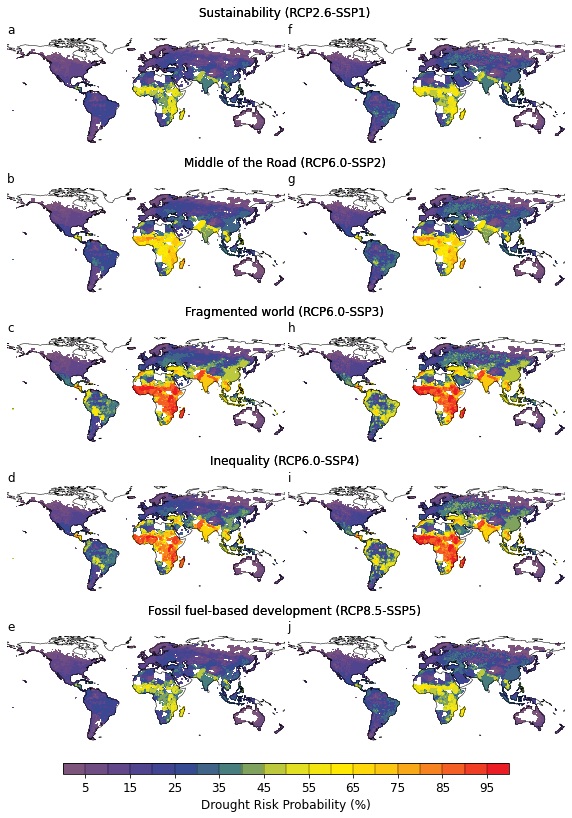

In [31]:
Ti = 1 # index for 2071-2100
thi = 1 # \tau index
scs = [(0,0), (1,1), (1,2), (1,3), (2,4)]
ys = np.stack([ds['IRI'][:, ri,si,thi,Ti].values.reshape(2,nlat,nlon) for ri,si in scs])
titles = ['Sustainability (RCP2.6-SSP1)', 'Middle of the Road (RCP6.0-SSP2)', 'Fragmented world (RCP6.0-SSP3)', 
          'Inequality (RCP6.0-SSP4)', 'Fossil fuel-based development (RCP8.5-SSP5)']
levels = np.arange(0,1.01,0.05)*100
cm = ['#7C547C', '#5C448C', '#344494', '#48807C',
      '#DCDC2C', '#FFEA00', '#FCC311', '#F46C24', '#EC1C24']
cmap = mpl.colors.LinearSegmentedColormap.from_list('cm', cm, N=levels.size-1)
fig, axes = plt.subplots(5,2, sharex=True, sharey=True,
                         figsize=(10,16), gridspec_kw={'wspace':0.01, 'hspace':0.2},
                         subplot_kw={'projection': ccrs.PlateCarree()}, )
plt.subplots_adjust(hspace=0)
for i in range(2):
    for ss in range(5):
        ax = axes[ss, i]
        ax.coastlines(linewidth=0.5, resolution="110m")
        yy = np.ma.masked_equal(ys[ss,i]*100, 0)
        cs = ax.contourf(lons, lats, yy, levels=levels,cmap=cmap,transform=ccrs.PlateCarree())
        ax.background_patch.set_visible(False)
        ax.outline_patch.set_visible(False)
        #ax.set_title(cols[ss])
        axes[ss, 0].annotate(titles[ss], xy=(1.,1.2), xycoords='axes fraction', fontsize=12, 
                     horizontalalignment='center')

cbar = fig.colorbar(cs, ax=axes, orientation='horizontal', pad=0.02, shrink=0.8, drawedges=True, aspect=40,
                    extendfrac='auto', spacing='uniform', ticks=levels[1::2])
cbar.ax.set_xlabel('Drought Risk Probability (%)', fontsize=12)
cbar.ax.tick_params(labelsize=12)
axesls = np.stack([axes.ravel()[::2], axes.ravel()[1::2]])
label_axes(axesls.ravel(), loc=(0., 1.05), fontsize=12)

# 4. People at risk

# 4.1 Load and prepare

In [4]:
infile = '../../2_pipeline/global_iri_smd/store/expths/iri_exp.nc'
ds = xr.load_dataset(infile)

In [5]:
thi = 1 # \tau index
Ti = 1 # 2071-2100 index
iriexp = ds['IRIexp'].values[:,:,:,:, thi, Ti]
iriexp_glob = ds['IRIexp_glob'].values[:,:,:,:, thi, Ti]
iriexp_clim = ds['IRIexp_clim'].values[:,:,:, thi, Ti]
iriexp_clim_glob = ds['IRIexp_clim_glob'].values[:,:,:, thi, Ti]
iriexp_ssp = ds['IRIexp_ssp'].values[:,:,:, thi, Ti]
iriexp_ssp_glob = ds['IRIexp_ssp_glob'].values[:,:,:, thi, Ti]

In [9]:
scs = [(0,0), (1,1), (1,2), (1,3), (2,4)]
cols = [rcps[ri]+'-'+sspsn[si] for ri,si in scs]
tmp = np.stack([iriexp[:, :,ri,si] for ri,si in scs])
dstr = ['SMI', 'RI']
rclass = np.arange(0., 0.91, 0.1).tolist()
multidx = pd.MultiIndex.from_product((dstr, cols, rclass), names=['dd', 'scenarios', 'rclass'])
df_exp = pd.DataFrame(np.zeros((len(isos), len(multidx))), columns=multidx, index=isos)
for iso in isos:
    ci = isos.index(iso)
    vals = tmp[:,:,:,ci]
    for i in range(len(scs)):
        df_exp.loc[iso, (dstr, cols[i], rclass)] = vals[i].T.ravel()
df_exp.dropna(inplace=True)

In [10]:
devclass = ['high', 'low', 'global']
df_exp_dev = pd.DataFrame(np.zeros((len(multidx), len(devclass))), columns=devclass, index=multidx)
for col in cols:
    idx_code = un_hdi15_df[un_hdi15_df.loc[:, 'HDI_2015']>0.8].index.tolist()
    high = df_exp.loc[idx_code, (dstr, col)].sum(axis=0)
    df_exp_dev.loc[high.index, devclass[0]] = high
    idx_code = un_hdi15_df[un_hdi15_df.loc[:, 'HDI_2015']<0.55].index.tolist()
    low = df_exp.loc[idx_code, (dstr, col)].sum(axis=0)
    df_exp_dev.loc[low.index, devclass[1]] = low
tmp_glob = np.stack([iriexp_glob[:, :, ri,si] for ri,si in scs])
df_exp_dev.loc[:, 'global'] = tmp_glob.transpose(2,0,1).ravel()

In [11]:
# pop, clim contribution
tmp_cclim = iriexp_clim.transpose(1,2,0,3)
tmp_cpop = iriexp_ssp.transpose(1,2,0,3)

dstr = ['SMI', 'RI']
multidxc = pd.MultiIndex.from_product((dstr, sspsn+rcps, rclass), names=['dd', 'scenarios', 'rclass'])
df_exp_contrib = pd.DataFrame(np.zeros((len(isos), len(multidxc))), columns=multidxc, index=isos)
for iso in isos:
    ci = isos.index(iso)
    df_exp_contrib.loc[iso, (dstr, sspsn, rclass)] = tmp_cpop[:,:,:, ci].ravel()
    df_exp_contrib.loc[iso, (dstr, rcps, rclass)] = tmp_cclim[:,:,:, ci].ravel()

devclass = ['high', 'low', 'global']
df_exp_contrib_dev = pd.DataFrame(np.zeros((len(multidxc), len(devclass))), columns=devclass, index=multidxc)
for col in sspsn:
    idx_code = un_hdi15_df[un_hdi15_df.loc[:, 'HDI_2015']>0.8].index.tolist()
    high = df_exp_contrib.loc[idx_code].sum(axis=0)
    df_exp_contrib_dev.loc[high.index, devclass[0]] = high

    idx_code = un_hdi15_df[un_hdi15_df.loc[:, 'HDI_2015']<0.55].index.tolist()
    low = df_exp_contrib.loc[idx_code].sum(axis=0)
    df_exp_contrib_dev.loc[low.index, devclass[1]] = low

In [12]:
tmp_cclim_glob = iriexp_clim_glob.transpose(1,2,0)
tmp_cpop_glob = iriexp_ssp_glob.transpose(1,2,0)
df_exp_contrib_dev.loc[(dstr, sspsn, rclass), 'global'] = tmp_cpop_glob.ravel()
df_exp_contrib_dev.loc[(dstr, rcps, rclass), 'global'] = tmp_cclim_glob.ravel()

In [13]:
cclass = ['cchigh', 'cclow', 'ccglob', 'cphigh', 'cplow', 'cpglob']
df_ccp = pd.DataFrame(np.zeros((len(multidx), len(cclass))), columns=cclass, index=multidx)
for col in cols:
    r, s = col.split('-')
    tt = df_exp_contrib_dev.loc[(dstr, [s,r], rclass)].sum(axis=0, level=(0,2))
    cpop = df_exp_contrib_dev.loc[(dstr, s, rclass)]/tt
    cclim = df_exp_contrib_dev.loc[(dstr, r, rclass)]/tt
    df_ccp.loc[(dstr, col, rclass), cclass[:3]] = cclim.values
    df_ccp.loc[(dstr, col, rclass), cclass[3:]] = cpop.values
df_ccp.replace(np.nan, 0, inplace=True)

<ipython-input-13-639fbb9fba15>:5: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  tt = df_exp_contrib_dev.loc[(dstr, [s,r], rclass)].sum(axis=0, level=(0,2))


# 4.2 Plots

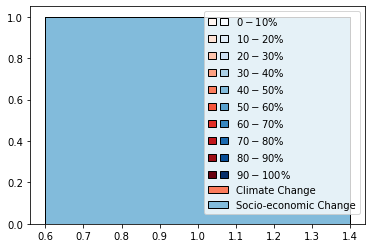

In [14]:
# Custom Legend
from matplotlib.legend_handler import HandlerTuple
handles = []
norm = mpl.colors.Normalize(vmin=0, vmax=0.9)
cmap1 = mpl.cm.get_cmap('Reds')
cmap2 = mpl.cm.get_cmap('Blues')
colorfn = [cmap1, cmap2]
for thi in range(len(rclass)):
    p1 = plt.bar([1], [1], color=colorfn[0](norm(rclass[thi])), edgecolor='k', lw=1.0)
    p2 = plt.bar([1], [1], color=colorfn[1](norm(rclass[thi])), edgecolor='k', lw=1.0)
    handles.append((p1,p2))
p1 = plt.bar([1], [1], color=colorfn[0](norm(rclass[4])), edgecolor='k', lw=1.0)
p2 = plt.bar([1], [1], color=colorfn[1](norm(rclass[4])), edgecolor='k', lw=1.0)
handles.append(p1)
handles.append(p2)
dcnames = ['${0}-{1}$%'.format(int(r*100), int(r*100+10)) for r in rclass]
scnames = ['Climate Change', 'Socio-economic Change']
plt.legend(handles, dcnames+scnames, handler_map={tuple: HandlerTuple(ndivide=None)})

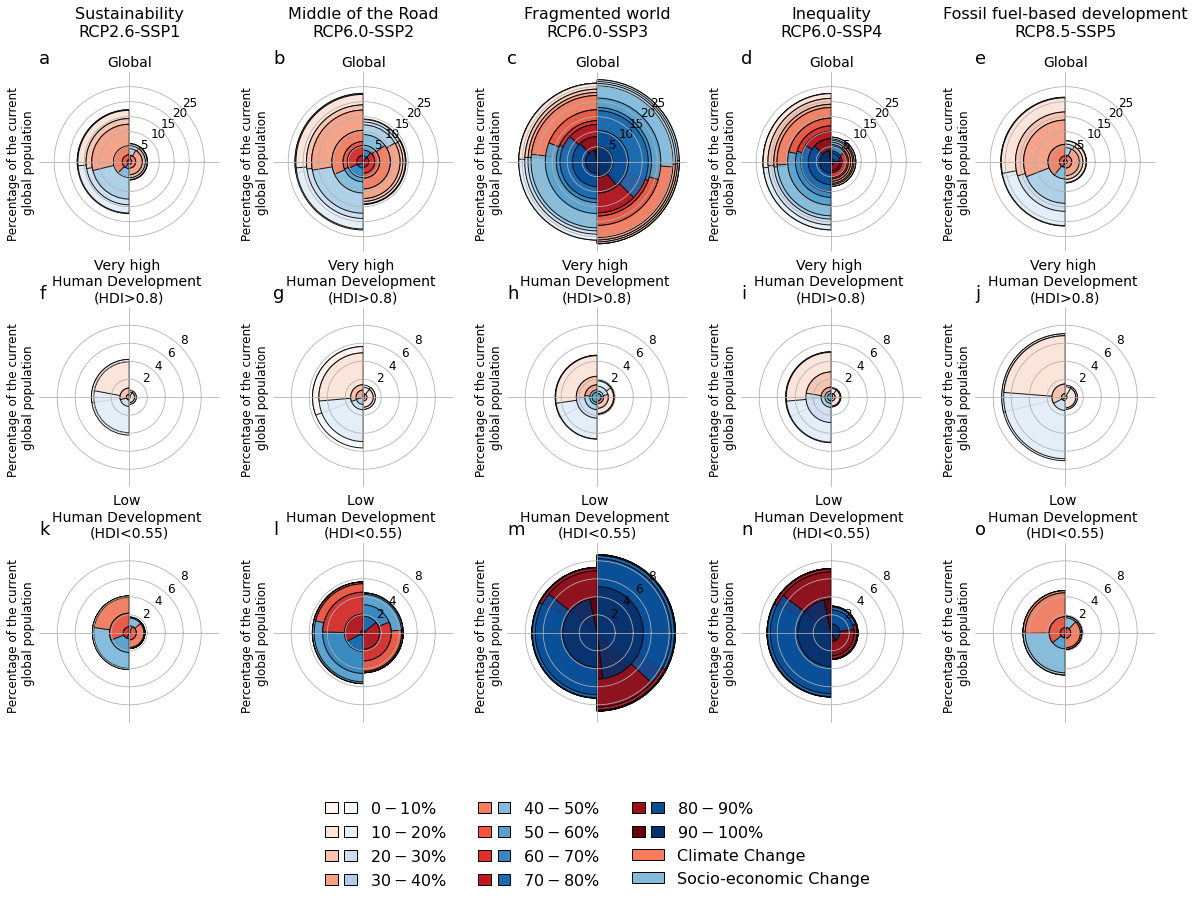

In [16]:
# Global and devlopment
def cstm_autumn_r(x):
    return plt.cm.autumn_r(x)

norm = mpl.colors.Normalize(vmin=0, vmax=0.9)
cmap1 = mpl.cm.get_cmap('Reds')
cmap2 = mpl.cm.get_cmap('Blues')
colorfn = [cmap1, cmap2]
mpl.rcParams['mathtext.fontset'] = 'dejavusans' # Default 'dejavusans'

colorp =  ['#F0433A', '#C9283E', '#820333', '#540032', '#2E112D']
colorp_blue = ['#ADD5F7', '#7FB2F0', '#4E7AC7', '#35478C', '#16193B']
colorx = [colorp, colorp_blue]
rows = ['global','high', 'low']
idx_ccp = [['ccglob', 'cpglob'], ['cchigh', 'cphigh'], ['cclow', 'cplow']]
x0 = [0, np.pi]
x1 = [-1/2, 1/2]
pop2020 = 7757983000
factor = [3.405*10**9, 6.895*10**9]
titles = ['Global', 'Very high \nHuman Development \n(HDI>0.8)', 
          'Low \nHuman Development \n(HDI<0.55)']
# top_titles = ['RCP2.6-SSP1', 'RCP6.0-SSP3', 'RCP8.5-SSP5']
top_titles = ['Sustainability\nRCP2.6-SSP1', 'Middle of the Road\nRCP6.0-SSP2',
              'Fragmented world\nRCP6.0-SSP3', 'Inequality\nRCP6.0-SSP4',
              'Fossil fuel-based development\nRCP8.5-SSP5']

fig, axes = plt.subplots(3, 5, figsize=(20,12), sharey=False, #dpi=300,
                         subplot_kw={'projection':'polar'}, 
                         gridspec_kw={'hspace':0.3, 'wspace':0.3})
# top_titles = ['Sustainability\nRCP2.6-SSP1', 'Fragmented world\nRCP6.0-SSP3', 
#               'Fossil fuel-based development\nRCP8.5-SSP5']
for cc in range(3):
    for ss in range(5):
        ax = axes[cc,ss]
        for i in range(2):
            ys = df_exp_dev.loc[(dstr[i], cols[ss]), rows[cc]].values/factor[i]*100#10**8#pop2020*100
            ys_cont = df_ccp.loc[(dstr[i], cols[ss]), idx_ccp[cc]].values
            for thi in range(len(rclass)):
                cci, cpi = ys_cont[thi]
                theta = [np.pi*cci, np.pi]
                xx = [x1[i]*np.pi + theta[0]/2, x0[i]]
                for xi in [1,0]:
                    if ys[thi] == 0:
                        continue
                    ax.bar(xx[xi], ys[thi], width=theta[xi], bottom=0.0, alpha=0.9, 
                           facecolor=colorfn[xi](norm(rclass[thi])), edgecolor='k', lw=1.0)
        
        ax.set_xticks([0, np.pi/2, np.pi, np.pi+np.pi/2])
        ax.set_xticklabels([])
        ax.spines['polar'].set_visible(False)
        ax.set_rlabel_position(45)  # Move radial labels away from plotted line
        ax.grid(True)
        ax.set_ylabel('Percentage of the current \nglobal population', fontsize=12)
        ax.set_title(titles[cc], fontsize=14)
        ax.tick_params(axis="y", labelleft=True, which='major', labelsize=12)
for ss in range(5):
    ax = axes[0,ss]
    ax.annotate(top_titles[ss], xy=(0.5,1.2), xycoords='axes fraction', fontsize=16, 
                     horizontalalignment='center')
    ax.set_ylim(0, 30)
    ax.set_yticks(np.arange(5,30,5))
for ax in axes[1:].ravel():
    ax.set_ylim(0, 10)
    ax.set_yticks(np.arange(2,10,2))

axes[-1,2].legend(handles, dcnames+scnames, bbox_to_anchor=(0.5, -1), loc='lower center',
                 frameon=False, ncol=3, fontsize=16,
                 handler_map={tuple: HandlerTuple(ndivide=None)})
label_axes(axes.ravel(), loc=(0., 1.05), fontsize=18)

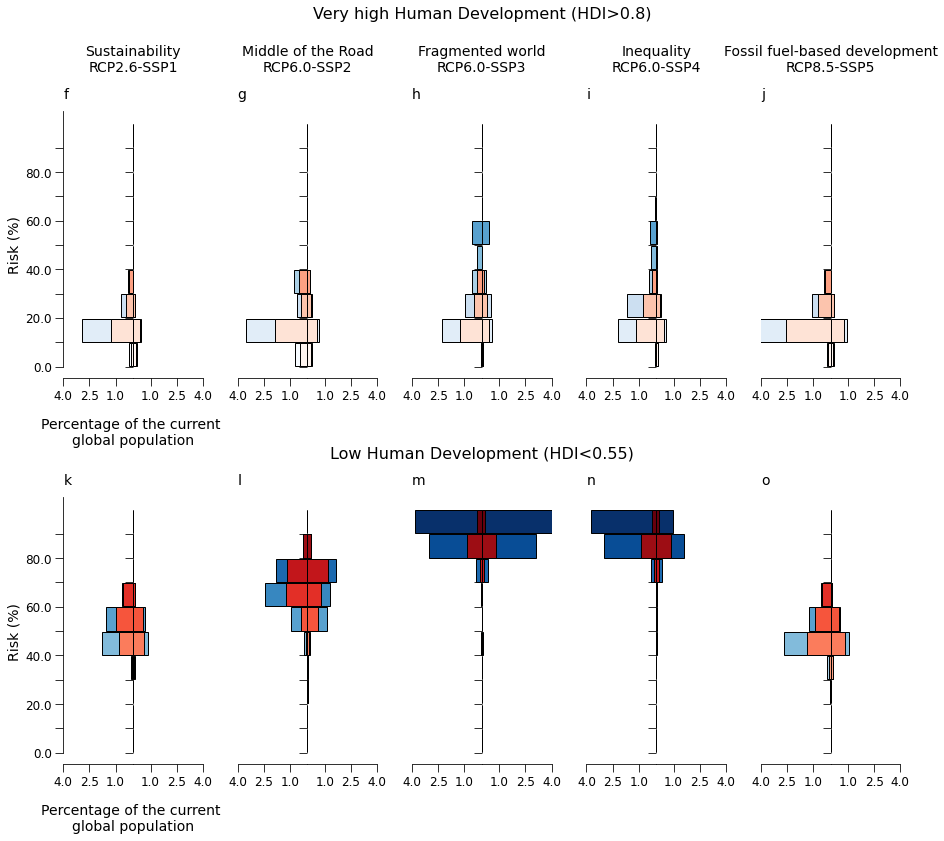

In [43]:
titles = ['Global', 'Very high Human Development (HDI>0.8)', 
          'Low Human Development (HDI<0.55)']
wth = [1,1,0.5,1,1,0.5,1,1,0.5,1,1,0.5,1,1]
fig, axes = plt.subplots(2, 14, figsize=(15, 12), 
                         gridspec_kw={'hspace':0.45, 'wspace':0.0, 'width_ratios':wth})
xticks = [np.arange(1,4.6,1.5), np.arange(1, 5.1, 1)]
yticklabels = [ 0., '', 20., '', 40., '', 60., '', 80., '']
xticklabels = [0.5, '' , 1.5, '' , 2.5, '', 3.5]
for ax in axes[:, [2,5,8,11]].ravel():
    ax.remove()
axes = axes[:, [0,1,3,4,6,7,9,10,12,13]].reshape(2,5,2)
for ss in range(5):
    for cc in range(2):
        for i in range(2):
            ys = df_exp_dev.loc[(dstr[i], cols[ss], rclass), rows[cc+1]]/factor[i]*100
            ys = np.hstack([ys.values[:-1]-ys.values[1:], ys.values[-1]])
            ys_cont = df_ccp.loc[(dstr[i], cols[ss], rclass), idx_ccp[cc+1][0]]
            ys_cont = ys*ys_cont.values
            ax = axes[cc, ss][::-1][i]
            ax.barh(rclass, ys, 0.095, color=colorfn[1](norm(rclass)), edgecolor='k')
            ax.barh(rclass, ys_cont, 0.095, color=colorfn[0](norm(rclass)), edgecolor='k')
            ax.set_yticks([])
            ax.set_yticklabels([])
            ax.set_xlim(0,xticks[0].max())
            ax.set_xticks(xticks[0])
            ax.set_xticklabels(xticks[0])
            sns.despine(ax=ax, left=True)
            ax.set_yticks(np.array(rclass)-0.05)
            ax.tick_params("both", length=8, which="major", labelsize=12)
        sns.despine(ax=axes[cc,0,0], left=False)
        axes[cc,ss,0].invert_xaxis()
        axes[cc,0,0].set_yticklabels(yticklabels, fontsize=12)
        axes[cc,0,0].spines['left'].set_bounds(-0.05, 1.)
        if ss>0:
            axes[cc,ss,0].set_yticks([]);
for ax in axes[:, 0, 0]:
    ax.set_ylabel('Risk (%)', fontsize=14)
    ax.annotate('Percentage of the current \nglobal population', xy=(1,-0.25), xycoords='axes fraction', 
                             horizontalalignment='center', fontsize=14)

axes[0,2,0].annotate(titles[1], xy=(1,1.35), xycoords='axes fraction', fontsize=16, horizontalalignment='center')
axes[1,2,0].annotate(titles[2], xy=(1,1.15), xycoords='axes fraction', fontsize=16, horizontalalignment='center')
for ss, ax in enumerate(axes[0,:,0]):
    ax.annotate(top_titles[ss], xy=(1,1.15), xycoords='axes fraction', fontsize=14, horizontalalignment='center')
label_axes(axes.ravel()[::2], labels=list('fghijklmno'), loc=(0., 1.05), fontsize=14)